# Análises estatísticas para gestão de processos

Este notebook foi desenvolvido por [Paulo Araujo](mailto:paulo@visiumlabs.com.br) com inspiração no tutorial desenvolvido por [Michael Allen](https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/) e tem por objetivo demonstrar a técnica [Chi-square](https://en.wikipedia.org/wiki/Chi-squared_test) para detecção de distribuição a partir de uma amostragem de dados quando estamos modelando digitalmente um sistema a fim de se realizar análises estratégicas do mesmo.

## Pacotes do Python

Neste exemplo utilizaremos a biblioteca [Numpy](https://numpy.org) para geração de números aleatórios e cálculos estatísticos. [Pandas](https://pandas.pydata.org) para resumir estatisticamente os dados. [Scipy](https://www.scipy.org) para avaliações estatísticas dos dados e [Matplotlib](https://matplotlib.org) para criação de gráficos.

In [62]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

Vamos supor que os dados foram coletados e armazenados em um arquivo `txt` no diretório `C:\Temp`.

In [63]:
amostras = np.loadtxt("C:\Temp\sample500.txt")

Vamos resumir estatisticamente os dados com Pandas, lembrando que nós não sabemos qual função de distribuição o processo segue.

In [64]:
info = pd.DataFrame(amostras, columns=['Data'])
info.describe()

,Data
count,500.000000
mean,0.099825
std,0.020618
min,0.025055
25%,0.086653
50%,0.100736
75%,0.113960
max,0.163096


Vamos criar uma lista de distribuições candidatas para nossa amostragem. Veja esse [link](https://docs.scipy.org/doc/scipy/reference/stats.html) para obter uma lista completa de todas as distribuições disponíveis no Scipy.


In [65]:
dist_names = ['expon',
              'gamma',
              'lognorm',
              'norm',
              'erlang',
              'triang',
              'uniform',
              'pareto',
              'cauchy',
              'weibull_min', 
              'weibull_max']

Calculando o número de classes baseado no tamanho da amostra.

In [66]:
k = int(np.sqrt(amostras.shape[0]))

Criando algumas variáveis para armazenar os resultados dos testes.

In [67]:
chi_square = []
params = []

Calculando os limites das classes para desenvolvimento do histograma.

In [68]:
percentile_bins = np.linspace(0,100,k)
percentile_cutoffs = np.percentile(info, percentile_bins)
observed_frequency, bins = (np.histogram(info, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

Visualizando o histograma de acordo com as classes previamente definidas.

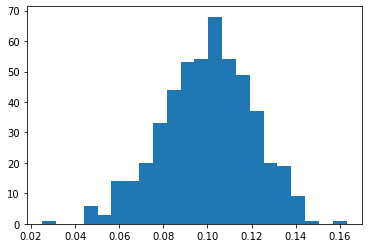

In [69]:
plt.hist(amostras,k)
plt.show()

Desativando os alertas que podem ser disparados no momento dos testes.

In [70]:
import warnings
warnings.filterwarnings("ignore")

Looping para testar todas as distribuições previamente definidas.

In [71]:
for distribution in dist_names:
    # Calcula os parâmetros de ajuste da distribuição atual
    dist = getattr(st, distribution)
    param = dist.fit(amostras)
    
    # Obtem as contagens esperadas nas classes
    # Isso é baseado em uma 'função de distribuição cumulativa' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # Calculo do chi-squared
    expected_frequency = np.array(expected_frequency) * amostras.shape[0]
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
    params.append(param)

Criando um Dataframe para ordenar os resultados a partir dos valores retornados pelo teste de Chi-Square.

In [72]:
results = pd.DataFrame()
results['Distribuição'] = dist_names
results['Chi Square'] = chi_square
results['Parâmetros'] = params
results.sort_values(['Chi Square'], inplace=True)
    
# Report results
print ('Distribuições classificadas pela qualidade do ajuste:')
print ('-----------------------------------------------------')
print (results[['Distribuição','Chi Square']])

Distribuições classificadas pela qualidade do ajuste:
-----------------------------------------------------
   Distribuição   Chi Square
9   weibull_min     1.503602
3          norm     4.310739
2       lognorm     4.548767
10  weibull_max     6.658580
4        erlang     8.163991
1         gamma     8.810554
8        cauchy   104.162242
5        triang   275.261530
6       uniform  1452.515965
0         expon  3422.209922
7        pareto  4184.762226


Escolhendo uma distribuição para visualizar os resultados finais.

In [75]:
index = 9
print(f'Distruibuição: {results.loc[index]["Distribuição"]} => Parâmetros: {results.loc[index]["Parâmetros"]}')

Distruibuição: weibull_min => Parâmetros: (5.145744643963555, 0.006755375310104167, 0.10114345703135974)


Visualizando os resultados finais.

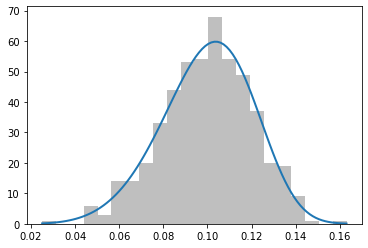

In [76]:
fig, ax = plt.subplots(1, 1)
h = ax.hist(amostras,k,color='0.75')

dist = getattr(st, results.loc[index]["Distribuição"])
param = dist.fit(amostras)
x = np.linspace(np.min(amostras),np.max(amostras),100)

pdf_fitted = dist.pdf(x,*param[:-2],param[-2],param[-1])
scale_pdf = np.trapz(h[0], h[1][:-1]) / np.trapz(pdf_fitted, x)
pdf_fitted *= scale_pdf

ax.plot(x,pdf_fitted,linewidth=2.0)

plt.show()